### Basic RNN (Recuurent Neural Network)
- 기존의 모델들은
 - 입력이 고정 길이여야 함.
 - 순서 정보를 직접 다루기 어려움

이라는 두 가지 문제가 있었다.

하지만 자연어는 순서가 핵심이며, 입력이 고정길이이면 안된다는 문제가 있다.

그래서 RNN 은 이전 정보를 다음 단계로 넘기는 구조로 이 문제를 해결했다.

### RNN의 핵심 구조
- RNN은 매 시점마다 아래 내용을 수행한다.
 - 현재 입력 x(t)
 - 이전 hidden state h(t-1)
위 두 정보를 이용해서
 - 새로운 hidden state h(t) 를 만들어낸다.
 - 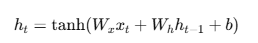
 - 수식으로 표현하면 위와 같다.


### RNN에 대한 직관적 이해
 - 지금까지 읽은 내용을 hidden state 에 요약해서
 - 하나의 벡터 (hidden state) 에 계속 업데이트 하는 과정
 - hidden state 는 과거 정보, 현재 입력을 섞은 요약본이 된다.

### RNN의 장점
 - 구조가 단순하다
 - 구현이 쉽다.
 - 순차 데이터를 처리 할 수 있다.

그래서
 - 초기 언어모델
 - 시계열 데이터
 - 간단한 sequence 처리

등에 많이 사용되었었다.

추가적으로 여기서 사용된 데이터는

AIHub 에서

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=126 

데이터를 사용해서

이 데이터를 가공해서

data 폴더 아래에

영어를 src.txt / 한국어를 tgt.txt 로

저장 한 파일을 사용하고 있다.

또한 Vocab 학습에는 SentencePiece 를 사용하고 있다.

https://arxiv.org/pdf/1808.06226.pdf

https://github.com/google/sentencepiece

SentencePiece 에 대한 정보는 위를 참조.

In [1]:
import os, math, random, time
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
DATA_DIR = "./data"
SRC_PATH = os.path.join(DATA_DIR, "src.txt")
TGT_PATH = os.path.join(DATA_DIR, "tgt.txt")

def read_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.rstrip("\n") for line in f]

    out = []
    for s in lines:
        s = " ".join(s.split())
        if s:
            out.append(s)
    return out

src_lines = read_lines(SRC_PATH)[0:50000]
tgt_lines = read_lines(TGT_PATH)[0:50000]

assert len(src_lines) == len(tgt_lines), (len(src_lines), len(tgt_lines))
print("pairs:", len(src_lines))
print("SRC:", src_lines[0][:120])
print("TGT:", tgt_lines[0][:120])

pairs: 50000
SRC: Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible.
TGT: 'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다.


In [3]:
def split_pairs(src, tgt, train_ratio=0.98, dev_ratio=0.01, seed=0):
    n = len(src)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)

    n_train = int(n * train_ratio)
    n_dev = int(n * dev_ratio)

    train_idx = idx[:n_train]
    dev_idx   = idx[n_train:n_train+n_dev]
    test_idx  = idx[n_train+n_dev:]

    def take(idxs):
        return [src[i] for i in idxs], [tgt[i] for i in idxs]

    return take(train_idx), take(dev_idx), take(test_idx)

(train_src, train_tgt), (dev_src, dev_tgt), (test_src, test_tgt) = split_pairs(src_lines, tgt_lines)
len(train_src), len(dev_src), len(test_src)

(49000, 500, 500)

In [4]:
import sentencepiece as spm

DATA_DIR = "./data"
SRC_PATH = os.path.join(DATA_DIR, "src.txt")
TGT_PATH = os.path.join(DATA_DIR, "tgt.txt")

SP_DIR = "./spm"
os.makedirs(SP_DIR, exist_ok=True)

SRC_PREFIX = os.path.join(SP_DIR, "src_bpe")
TGT_PREFIX = os.path.join(SP_DIR, "tgt_bpe")
SRC_MODEL  = SRC_PREFIX + ".model"
TGT_MODEL  = TGT_PREFIX + ".model"

SRC_VOCAB_SIZE = 16000
TGT_VOCAB_SIZE = 16000

if not os.path.exists(SRC_MODEL):
    spm.SentencePieceTrainer.Train(
        input=SRC_PATH,
        model_prefix=SRC_PREFIX,
        vocab_size=SRC_VOCAB_SIZE,
        model_type="bpe",
        character_coverage=1.0,
        bos_id=1, eos_id=2, unk_id=0, pad_id=3
    )

if not os.path.exists(TGT_MODEL):
    spm.SentencePieceTrainer.Train(
        input=TGT_PATH,
        model_prefix=TGT_PREFIX,
        vocab_size=TGT_VOCAB_SIZE,
        model_type="bpe",
        character_coverage=1.0,
        bos_id=1, eos_id=2, unk_id=0, pad_id=3
    )

In [5]:
src_sp = spm.SentencePieceProcessor(); src_sp.load(SRC_MODEL)
tgt_sp = spm.SentencePieceProcessor(); tgt_sp.load(TGT_MODEL)

True

In [6]:
print("src vocab:", src_sp.get_piece_size())
print("tgt vocab:", tgt_sp.get_piece_size())

src vocab: 16000
tgt vocab: 16000


In [7]:
PAD_ID = 3
BOS_ID = 1
EOS_ID = 2

def encode_src(line: str):
    return src_sp.encode_as_ids(line)

def encode_tgt(line: str):
    return tgt_sp.encode_as_ids(line)

In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, src_lines, tgt_lines, max_len=128):
        self.src = src_lines
        self.tgt = tgt_lines
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, i):
        s = encode_src(self.src[i])[: self.max_len]
        t = encode_tgt(self.tgt[i])[: self.max_len]
        return s, t

def collate_fn(batch):
    src_seqs, dec_in_seqs, dec_y_seqs = [], [], []

    for s, t in batch:
        src = s + [EOS_ID]
        dec_in = [BOS_ID] + t
        dec_y  = t + [EOS_ID]

        src_seqs.append(torch.tensor(src, dtype=torch.long))
        dec_in_seqs.append(torch.tensor(dec_in, dtype=torch.long))
        dec_y_seqs.append(torch.tensor(dec_y, dtype=torch.long))

    src_pad = nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=PAD_ID)
    dec_in_pad = nn.utils.rnn.pad_sequence(dec_in_seqs, batch_first=True, padding_value=PAD_ID)
    dec_y_pad  = nn.utils.rnn.pad_sequence(dec_y_seqs, batch_first=True, padding_value=PAD_ID)

    src_len = torch.tensor([len(x) for x in src_seqs], dtype=torch.long)
    return src_pad, src_len, dec_in_pad, dec_y_pad

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, src_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(src_vocab_size, emb_dim, padding_idx=PAD_ID)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

    def forward(self, src, src_len):
        x = self.emb(src)  # (B, S, D)
        packed = nn.utils.rnn.pack_padded_sequence(x, src_len.cpu(), batch_first=True, enforce_sorted=False)
        _, h_n = self.rnn(packed)  # (L, B, H)
        return h_n

class DecoderRNN(nn.Module):
    def __init__(self, tgt_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(tgt_vocab_size, emb_dim, padding_idx=PAD_ID)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hid_dim, tgt_vocab_size)

    def forward(self, dec_in, h0):
        x = self.emb(dec_in)       # (B, T, D)
        out, h_n = self.rnn(x, h0) # out: (B, T, H)
        logits = self.fc(out)      # (B, T, V_tgt)
        return logits, h_n

class Seq2SeqRNN(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.2):
        super().__init__()
        self.enc = EncoderRNN(src_vocab_size, emb_dim, hid_dim, num_layers, dropout)
        self.dec = DecoderRNN(tgt_vocab_size, emb_dim, hid_dim, num_layers, dropout)

    def forward(self, src, src_len, dec_in):
        h = self.enc(src, src_len)
        logits, _ = self.dec(dec_in, h)
        return logits

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def translate_greedy(model, src_sentence: str, max_len=128):
    model.eval()
    src_ids = encode_src(src_sentence)[:max_len] + [EOS_ID]
    src = torch.tensor([src_ids], dtype=torch.long, device=device)
    src_len = torch.tensor([len(src_ids)], dtype=torch.long, device=device)

    h = model.enc(src, src_len)

    dec_ids = [BOS_ID]
    for _ in range(max_len):
        dec_in = torch.tensor([dec_ids], dtype=torch.long, device=device)
        logits, h = model.dec(dec_in[:, -1:], h)
        next_id = int(logits[:, -1, :].argmax(dim=-1).item())
        if next_id == EOS_ID:
            break
        dec_ids.append(next_id)

    return tgt_sp.decode_ids(dec_ids[1:])

In [ ]:
def set_seed(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, src_lines, tgt_lines, max_len=128):
        self.src = src_lines
        self.tgt = tgt_lines
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, i):
        s = encode_src(self.src[i])[: self.max_len]
        t = encode_tgt(self.tgt[i])[: self.max_len]
        return s, t

def collate_fn(batch):
    src_seqs, dec_in_seqs, dec_y_seqs = [], [], []

    for s, t in batch:
        src = s + [EOS_ID]
        dec_in = [BOS_ID] + t
        dec_y  = t + [EOS_ID]

        src_seqs.append(torch.tensor(src, dtype=torch.long))
        dec_in_seqs.append(torch.tensor(dec_in, dtype=torch.long))
        dec_y_seqs.append(torch.tensor(dec_y, dtype=torch.long))

    src_pad = nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=PAD_ID)
    dec_in_pad = nn.utils.rnn.pad_sequence(dec_in_seqs, batch_first=True, padding_value=PAD_ID)
    dec_y_pad  = nn.utils.rnn.pad_sequence(dec_y_seqs, batch_first=True, padding_value=PAD_ID)

    src_len = torch.tensor([len(x) for x in src_seqs], dtype=torch.long)
    return src_pad, src_len, dec_in_pad, dec_y_pad

In [ ]:
MAX_LEN = 64
BATCH_SIZE = 128

train_ds = PairDataset(train_src, train_tgt, max_len=MAX_LEN)
dev_ds   = PairDataset(dev_src, dev_tgt, max_len=MAX_LEN)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader   = torch.utils.data.DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

len(train_ds), len(dev_ds)

(49000, 500)

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def fmt(n):
    if n >= 1e6: return f"{n/1e6:.2f}M"
    if n >= 1e3: return f"{n/1e3:.2f}K"
    return str(n)

In [ ]:
def run_eval(model, loader):
    model.eval()
    total_loss = 0.0
    total_tok = 0
    with torch.no_grad():
        for src, src_len, dec_in, dec_y in loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            logits = model(src, src_len, dec_in)  # (B, T, Vt)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="sum"
            )
            total_loss += loss.item()
            total_tok += (dec_y != PAD_ID).sum().item()

    nll = total_loss / max(total_tok, 1)
    ppl = math.exp(nll)
    return nll, ppl


def train_epochs(model, train_loader, dev_loader, *, epochs=3, lr=5e-3, grad_clip=1.0, print_every=300):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_tok = 0
        step = 0
        t0 = time.time()

        for src, src_len, dec_in, dec_y in train_loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            opt.zero_grad()
            logits = model(src, src_len, dec_in)

            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="mean"
            )
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()

            with torch.no_grad():
                tok_cnt = (dec_y != PAD_ID).sum().item()
                total_loss += loss.item() * tok_cnt
                total_tok  += tok_cnt
                step += 1

            if step % print_every == 0:
                nll = total_loss / max(total_tok, 1)
                print(f"[epoch {ep} step {step}] train nll={nll:.4f} ppl={math.exp(nll):.2f}")

        train_nll = total_loss / max(total_tok, 1)
        train_ppl = math.exp(train_nll)

        dev_nll, dev_ppl = run_eval(model, dev_loader)
        dt = time.time() - t0
        print(f"[epoch {ep}] train ppl={train_ppl:.2f} | dev ppl={dev_ppl:.2f} | {dt:.1f}s")

    os.makedirs("./ckpt", exist_ok=True)

    ckpt_path = "./ckpt/rnn_seq2seq.pt"

    torch.save(
        {
            "model_type": "rnn_seq2seq",
            "state_dict": model.state_dict(),
            "tokenizer": {
                "src_spm_model": SRC_MODEL,
                "tgt_spm_model": TGT_MODEL,
                "pad_id": PAD_ID,
                "bos_id": BOS_ID,
                "eos_id": EOS_ID,
            }
        },
        ckpt_path
    )
    print(f"saved: {ckpt_path}")

In [ ]:
SRC_V = src_sp.get_piece_size()
TGT_V = tgt_sp.get_piece_size()

EMB_DIM = 1024
HID_DIM = 1024
NUM_LAYERS = 12
DROPOUT = 0.1

model = Seq2SeqRNN(
    src_vocab_size=SRC_V,
    tgt_vocab_size=TGT_V,
    emb_dim=EMB_DIM,
    hid_dim=HID_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print("RNN params:", fmt(count_params(model)))

RNN params: 99.55M


In [ ]:
train_epochs(
    model,
    train_loader,
    dev_loader,
    epochs=1,
    lr=5e-3,
    grad_clip=1.0,
    print_every=300
)

[epoch 1 step 300] train nll=10.6733 ppl=43187.96
[epoch 1 step 600] train nll=10.6725 ppl=43150.58
[epoch 1 step 900] train nll=10.7351 ppl=45940.06
[epoch 1 step 1200] train nll=10.7490 ppl=46584.86
[epoch 1 step 1500] train nll=10.7187 ppl=45195.19
[epoch 1 step 1800] train nll=10.7184 ppl=45178.75
[epoch 1 step 2100] train nll=10.7038 ppl=44524.62
[epoch 1 step 2400] train nll=10.6834 ppl=43623.84
[epoch 1 step 2700] train nll=10.6688 ppl=42995.07
[epoch 1 step 3000] train nll=10.6599 ppl=42612.36
[epoch 1 step 3300] train nll=10.6500 ppl=42191.24
[epoch 1 step 3600] train nll=10.6370 ppl=41645.98
[epoch 1 step 3900] train nll=10.6268 ppl=41225.37
[epoch 1 step 4200] train nll=10.6231 ppl=41072.19
[epoch 1 step 4500] train nll=10.6302 ppl=41366.00
[epoch 1 step 4800] train nll=10.6278 ppl=41267.45
[epoch 1 step 5100] train nll=10.6430 ppl=41898.89
[epoch 1 step 5400] train nll=10.6525 ppl=42298.03
[epoch 1 step 5700] train nll=10.6697 ppl=43031.39
[epoch 1 step 6000] train nll=10.6

KeyboardInterrupt: 

### RNN의 문제점
 - Long-term dependency 문제
  - 문장이 길어질수록 앞의 정보가 점점 희석되었다.
  - 학습시 gradienct 가 사라지는 문제가 생겼다.
  - RNN의 hidden state 는 기억을 계속 덮어쓰고 있는 hidden state 이다.

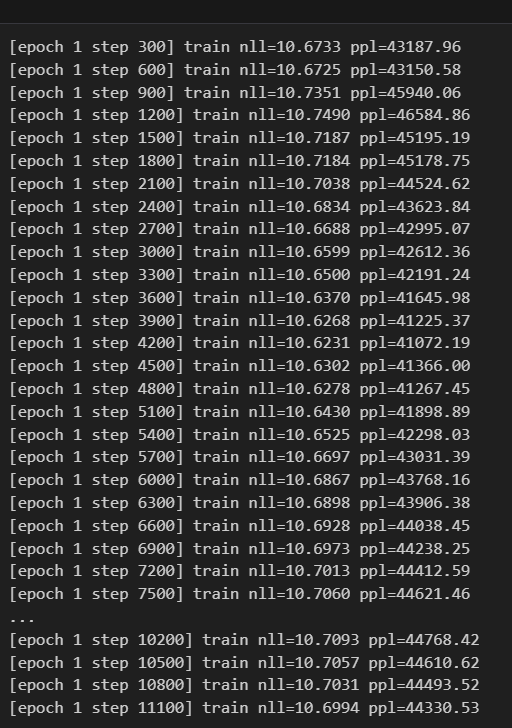

1epoch 를 다 도는동안 train negative likielyhood loss (nll) 가 전혀 줄어들지 않는 모습을 보여준다.
-log(x) = 10.7060 이라면
x 는 약 1/44000 정도 되는 값인데

이것은 44000 개 정도에서 하나를 찍는것과 유사한 결과를 얻고 있다고 볼 수 있다.

원래 vocab 이 16000이니까 그냥 완전히 못 맞추는 것.

이렇게 RNN Only 로만 하면 문장학습조차 거의 되지 않는것을 알 수 있다.

아주 간단한 몇 단어의 문장은 가능한데...

이를 해결하기 위해서 LSTM이 나왔다.

기본적인 RNN 구조는 이렇게 생겼다.

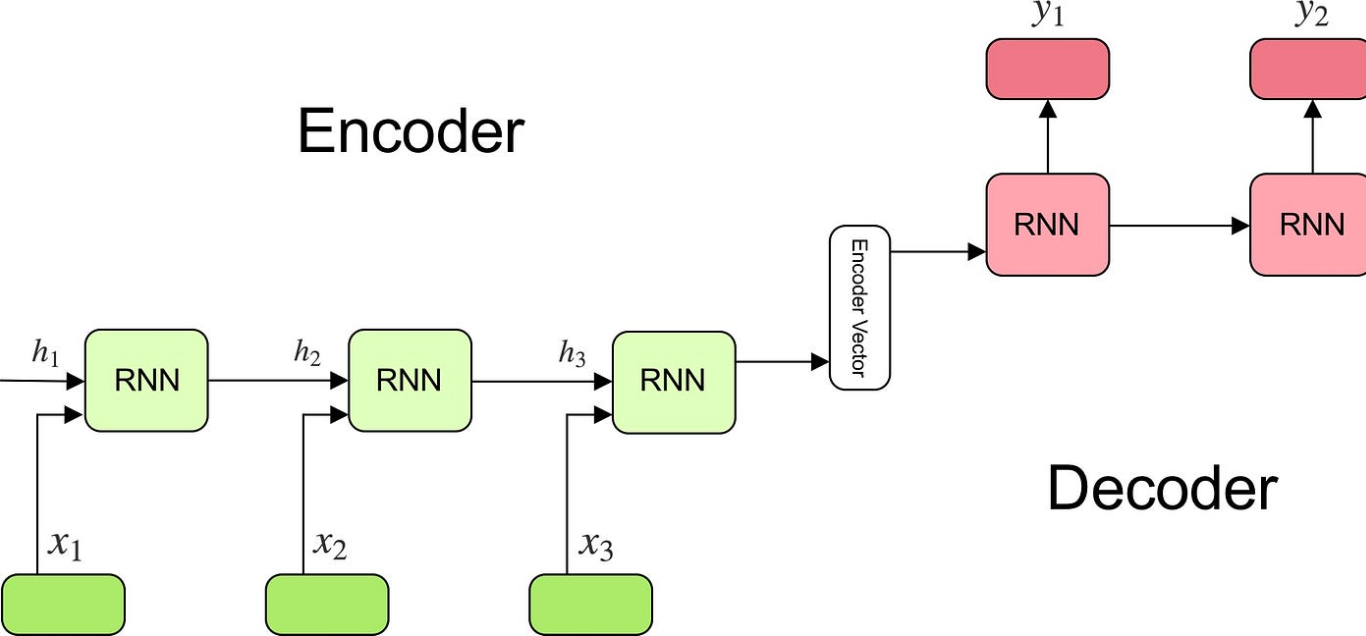

RNN으로 번역을 하는 과정은 아래와 같았다.

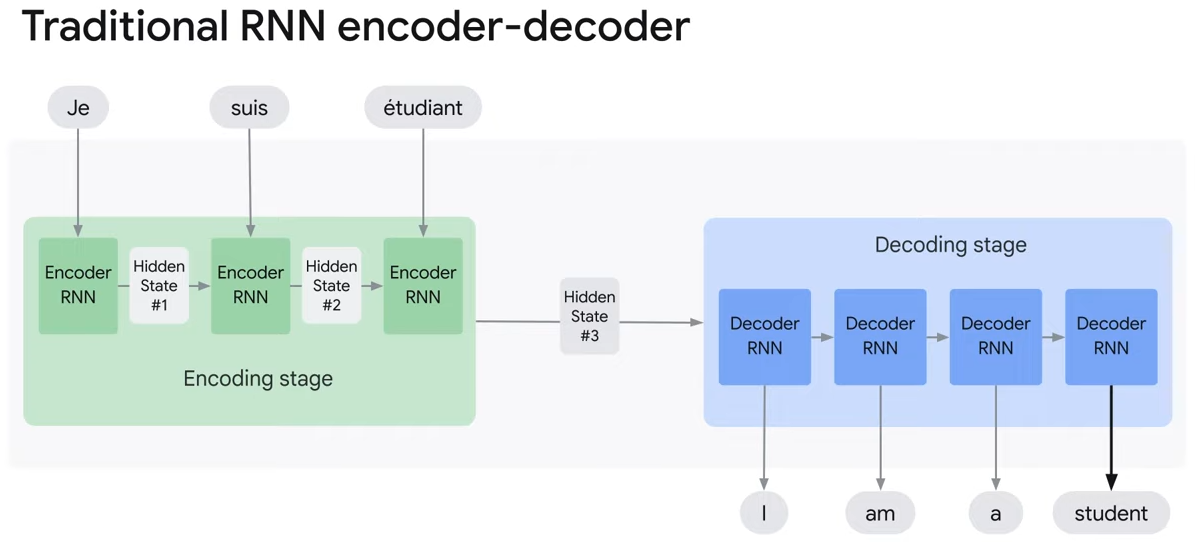

LSTM 은 기억을 좀 더 강화할 필요가 있다고 생각해서 Cell State 라는 것을 같이 넘겨준다.


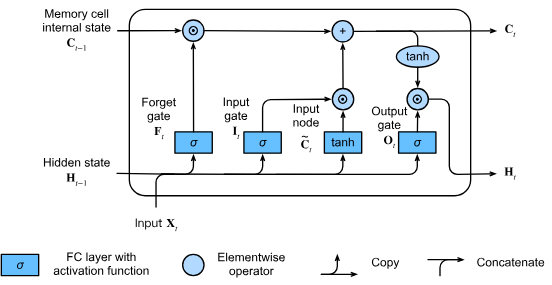


전체 구조는 아래와 같다.

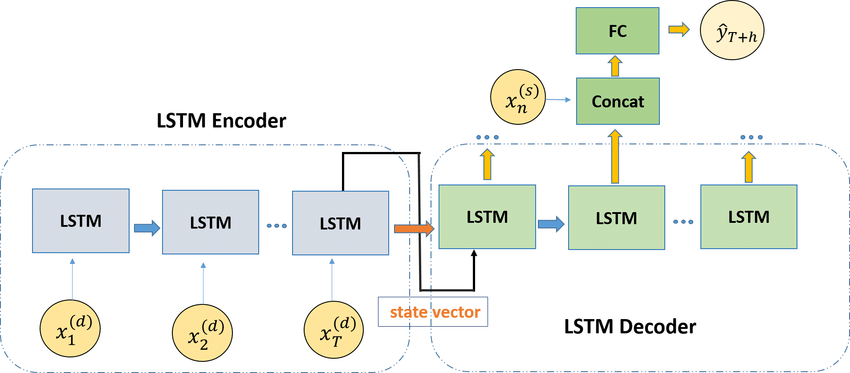

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, src_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(src_vocab_size, emb_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

    def forward(self, src, src_len):
        x = self.emb(src)  # (B, S, D)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, src_len.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, c_n) = self.lstm(packed)  # each: (L, B, H)
        return (h_n, c_n)

class DecoderLSTM(nn.Module):
    def __init__(self, tgt_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(tgt_vocab_size, emb_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hid_dim, tgt_vocab_size)

    def forward(self, dec_in, state):
        # state: (h, c)
        x = self.emb(dec_in)                 # (B, T, D)
        out, state = self.lstm(x, state)     # out: (B, T, H)
        logits = self.fc(out)                # (B, T, Vt)
        return logits, state

class Seq2SeqLSTM(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.enc = EncoderLSTM(src_vocab_size, emb_dim, hid_dim, num_layers, dropout)
        self.dec = DecoderLSTM(tgt_vocab_size, emb_dim, hid_dim, num_layers, dropout)

    def forward(self, src, src_len, dec_in):
        state = self.enc(src, src_len)          # (h, c)
        logits, _ = self.dec(dec_in, state)
        return logits


In [ ]:
def run_eval(model, loader):
    model.eval()
    total_loss = 0.0
    total_tok = 0
    with torch.no_grad():
        for src, src_len, dec_in, dec_y in loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            logits = model(src, src_len, dec_in)  # (B, T, Vt)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="sum"
            )
            total_loss += loss.item()
            total_tok += (dec_y != PAD_ID).sum().item()

    nll = total_loss / max(total_tok, 1)
    ppl = math.exp(nll)
    return nll, ppl


def train_epochs(model, train_loader, dev_loader, *, epochs=3, lr=5e-3, grad_clip=1.0, print_every=300):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_tok = 0
        step = 0
        t0 = time.time()

        for src, src_len, dec_in, dec_y in train_loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            opt.zero_grad()
            logits = model(src, src_len, dec_in)

            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="mean"
            )
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()

            with torch.no_grad():
                tok_cnt = (dec_y != PAD_ID).sum().item()
                total_loss += loss.item() * tok_cnt
                total_tok  += tok_cnt
                step += 1

            if step % print_every == 0:
                nll = total_loss / max(total_tok, 1)
                print(f"[epoch {ep} step {step}] train nll={nll:.4f} ppl={math.exp(nll):.2f}")

        train_nll = total_loss / max(total_tok, 1)
        train_ppl = math.exp(train_nll)

        dev_nll, dev_ppl = run_eval(model, dev_loader)
        dt = time.time() - t0
        print(f"[epoch {ep}] train ppl={train_ppl:.2f} | dev ppl={dev_ppl:.2f} | {dt:.1f}s")

    os.makedirs("./ckpt", exist_ok=True)

    ckpt_path = "./ckpt/lstm_seq2seq.pt"

    torch.save(
        {
            "model_type": "lstm_seq2seq",
            "state_dict": model.state_dict(),
            "tokenizer": {
                "src_spm_model": SRC_MODEL,
                "tgt_spm_model": TGT_MODEL,
                "pad_id": PAD_ID,
                "bos_id": BOS_ID,
                "eos_id": EOS_ID,
            }
        },
        ckpt_path
    )
    print(f"saved: {ckpt_path}")

In [ ]:
SRC_V = src_sp.get_piece_size()
TGT_V = tgt_sp.get_piece_size()

EMB_DIM = 1024
HID_DIM = 1024
NUM_LAYERS = 3
DROPOUT = 0.1

model_LSTM = Seq2SeqLSTM(
    src_vocab_size=SRC_V,
    tgt_vocab_size=TGT_V,
    emb_dim=EMB_DIM,
    hid_dim=HID_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print("LSTM params:", fmt(count_params(model_LSTM)))

LSTM params: 99.55M


In [ ]:
train_epochs(
    model_LSTM,
    train_loader,
    dev_loader,
    epochs=1,
    lr=5e-3,
    grad_clip=1.0,
    print_every=300
)

[epoch 1 step 300] train nll=7.7153 ppl=2242.35
[epoch 1 step 600] train nll=7.3791 ppl=1602.23
[epoch 1 step 900] train nll=7.1641 ppl=1292.20
[epoch 1 step 1200] train nll=7.0020 ppl=1098.81
[epoch 1 step 1500] train nll=6.8619 ppl=955.20
[epoch 1 step 1800] train nll=6.7461 ppl=850.73
[epoch 1 step 2100] train nll=6.6526 ppl=774.82
[epoch 1 step 2400] train nll=6.5742 ppl=716.36
[epoch 1 step 2700] train nll=6.5053 ppl=668.67
[epoch 1 step 3000] train nll=6.4461 ppl=630.21
[epoch 1 step 3300] train nll=6.3943 ppl=598.45
[epoch 1 step 3600] train nll=6.3471 ppl=570.83
[epoch 1 step 3900] train nll=6.3049 ppl=547.26
[epoch 1 step 4200] train nll=6.2655 ppl=526.08
[epoch 1 step 4500] train nll=6.2295 ppl=507.52
[epoch 1 step 4800] train nll=6.1959 ppl=490.72
[epoch 1 step 5100] train nll=6.1645 ppl=475.54
[epoch 1 step 5400] train nll=6.1353 ppl=461.88
[epoch 1 step 5700] train nll=6.1079 ppl=449.41
[epoch 1 step 6000] train nll=6.0821 ppl=437.93
[epoch 1 step 6300] train nll=6.0576 pp

아까 위에서 보았던 RNN 보다 train nll 이 훨씬 낮아진 것을 볼 수 있다.

다만 5만 문장을 해당 batch size 로 학습하는데도 6000초가 넘는 시간이 걸린다는 것을 알 수 있었다.

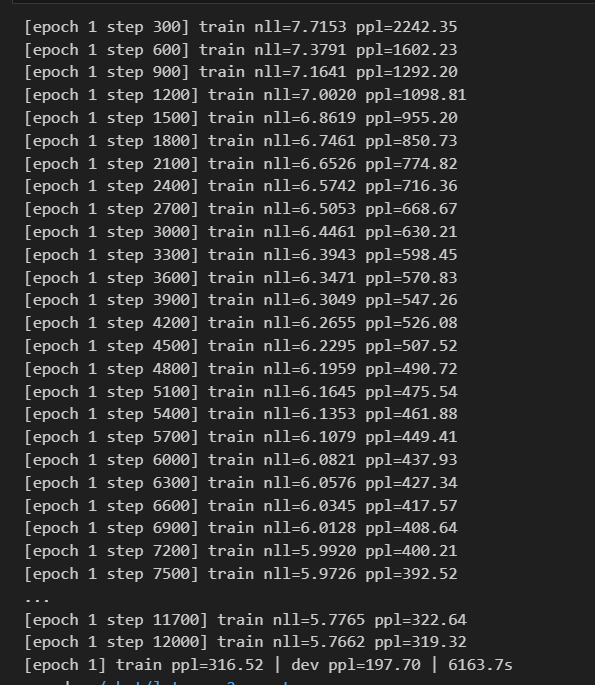

또한 기억을 강화하는 문제까지는 있었지만, 어디를 참조해야하는지에 대한 명확한 정보는 없었는데,

이를 해결하기 위해서 Attention 이라는 것을 도입했다.

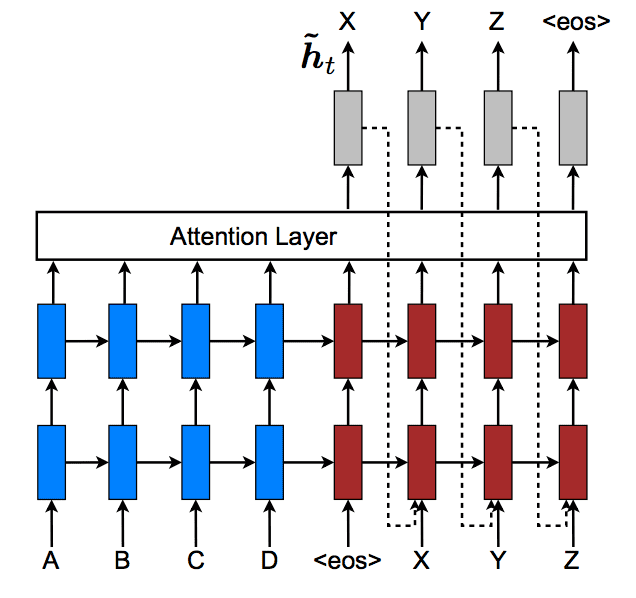

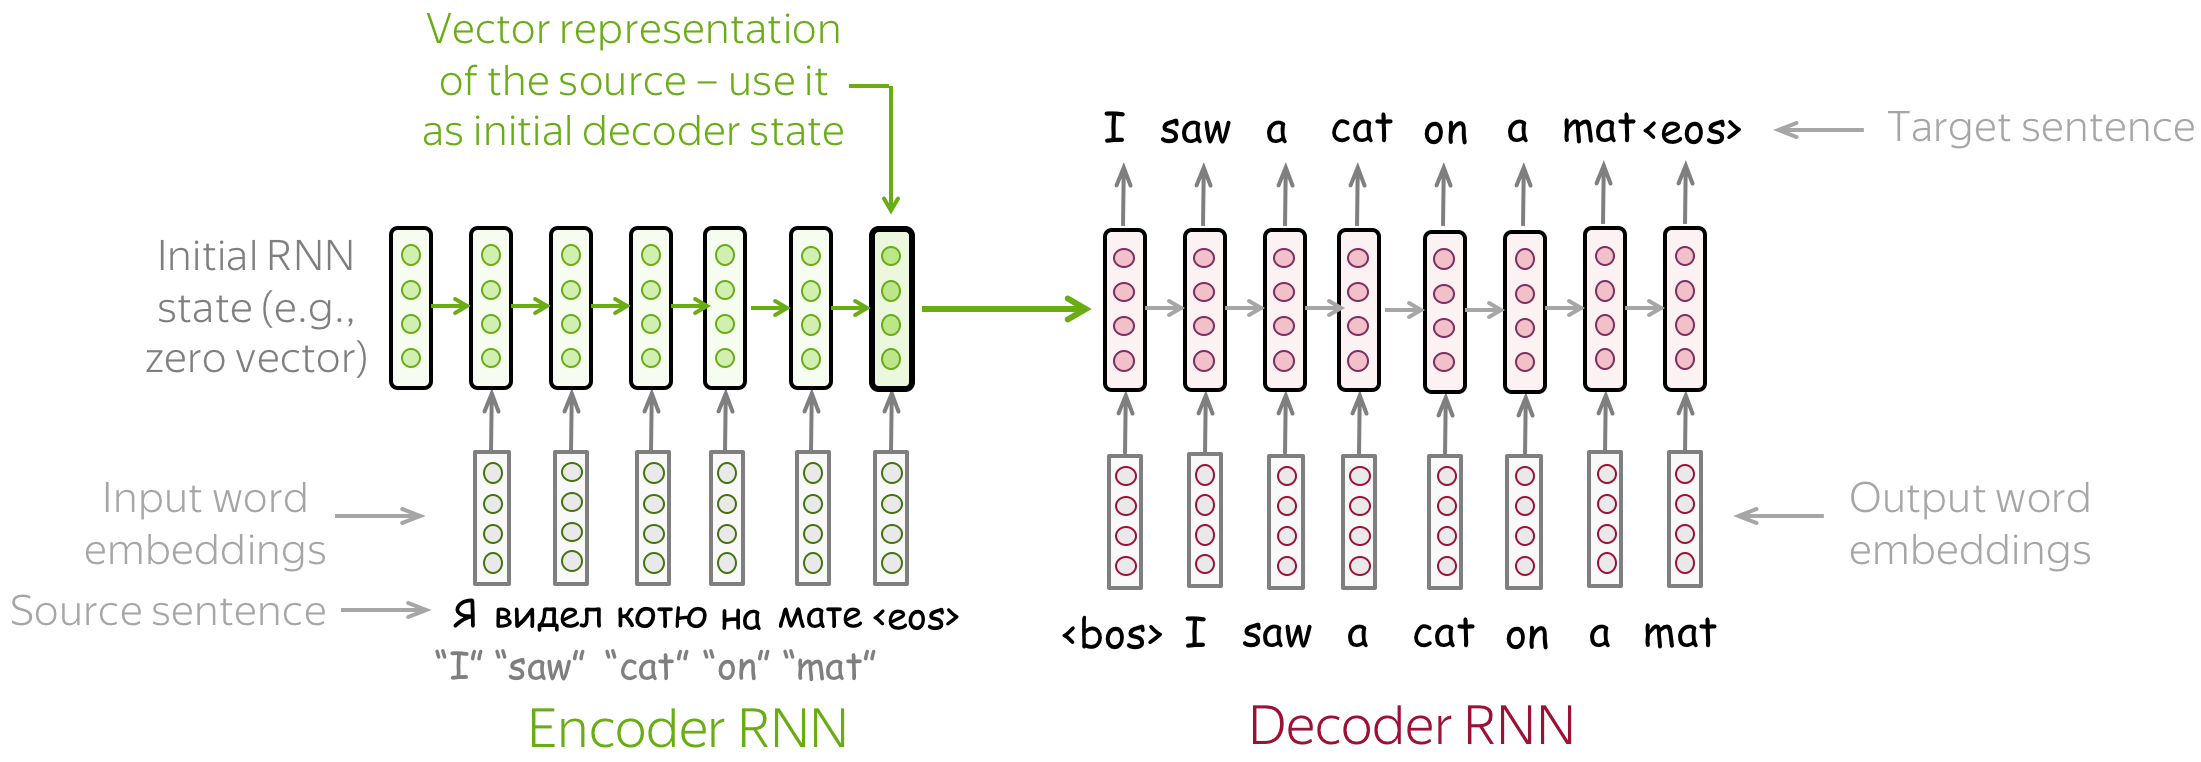

이 Attention만 단어를 가지고 계산함으로써,

이를 병렬적으로 활용할 수 있게 한 것이 Transformer 이다.

아래는 Transformer 를 간단하게 학습 시켜 본 것이고,

제대로된 학습 및, Transformer 구현은 5장 Attention is All you need 에서 할 것이다.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, T, D)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1)]

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=256,
        nhead=4,
        num_encoder_layers=3,
        num_decoder_layers=3,
        dim_feedforward=512,
        dropout=0.1,
        max_len=512,
    ):
        super().__init__()

        self.src_emb = nn.Embedding(src_vocab_size, d_model, padding_idx=PAD_ID)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model, padding_idx=PAD_ID)

        self.pos_enc = PositionalEncoding(d_model, max_len)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )

        self.fc = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, src_len, dec_in):
        # src: (B, S)
        # dec_in: (B, T)

        src_key_padding_mask = (src == PAD_ID)
        tgt_key_padding_mask = (dec_in == PAD_ID)

        # causal mask (T, T)
        T = dec_in.size(1)
        tgt_mask = torch.triu(
            torch.ones(T, T, device=dec_in.device), diagonal=1
        ).bool()

        src_emb = self.pos_enc(self.src_emb(src))
        tgt_emb = self.pos_enc(self.tgt_emb(dec_in))

        out = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
        )

        logits = self.fc(out)  # (B, T, Vt)
        return logits

In [ ]:
def run_eval(model, loader):
    model.eval()
    total_loss = 0.0
    total_tok = 0
    with torch.no_grad():
        for src, src_len, dec_in, dec_y in loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            logits = model(src, src_len, dec_in)  # (B, T, Vt)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="sum"
            )
            total_loss += loss.item()
            total_tok += (dec_y != PAD_ID).sum().item()

    nll = total_loss / max(total_tok, 1)
    ppl = math.exp(nll)
    return nll, ppl


def train_epochs(model, train_loader, dev_loader, *, epochs=3, lr=5e-3, grad_clip=1.0, print_every=300):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_tok = 0
        step = 0
        t0 = time.time()

        for src, src_len, dec_in, dec_y in train_loader:
            src, src_len = src.to(device), src_len.to(device)
            dec_in, dec_y = dec_in.to(device), dec_y.to(device)

            opt.zero_grad()
            logits = model(src, src_len, dec_in)

            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                dec_y.reshape(-1),
                ignore_index=PAD_ID,
                reduction="mean"
            )
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()

            with torch.no_grad():
                tok_cnt = (dec_y != PAD_ID).sum().item()
                total_loss += loss.item() * tok_cnt
                total_tok  += tok_cnt
                step += 1

            if step % print_every == 0:
                nll = total_loss / max(total_tok, 1)
                print(f"[epoch {ep} step {step}] train nll={nll:.4f} ppl={math.exp(nll):.2f}")

        train_nll = total_loss / max(total_tok, 1)
        train_ppl = math.exp(train_nll)

        dev_nll, dev_ppl = run_eval(model, dev_loader)
        dt = time.time() - t0
        print(f"[epoch {ep}] train ppl={train_ppl:.2f} | dev ppl={dev_ppl:.2f} | {dt:.1f}s")

    os.makedirs("./ckpt", exist_ok=True)

    ckpt_path = "./ckpt/transformer_seq2seq.pt"

    torch.save(
        {
            "model_type": "transformer_seq2seq",
            "state_dict": model.state_dict(),
            "tokenizer": {
                "src_spm_model": SRC_MODEL,
                "tgt_spm_model": TGT_MODEL,
                "pad_id": PAD_ID,
                "bos_id": BOS_ID,
                "eos_id": EOS_ID,
            }
        },
        ckpt_path
    )
    print(f"saved: {ckpt_path}")

In [ ]:
SRC_V = src_sp.get_piece_size()
TGT_V = tgt_sp.get_piece_size()

D_MODEL = 1024
NHEAD = 8
ENC_LAYERS = 3
DEC_LAYERS = 3
FF_DIM = 1024
DROPOUT = 0.1

model_tf = Seq2SeqTransformer(
    src_vocab_size=SRC_V,
    tgt_vocab_size=TGT_V,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=ENC_LAYERS,
    num_decoder_layers=DEC_LAYERS,
    dim_feedforward=FF_DIM,
    dropout=DROPOUT,
    max_len=512,
).to(device)

print("Transformer params:", fmt(count_params(model_tf)))

Transformer params: 99.58M


In [ ]:
train_epochs(
    model_tf,
    train_loader,
    dev_loader,
    epochs=3,
    lr=1e-4,
    grad_clip=1.0,
    print_every=300,
)

[epoch 1 step 300] train nll=5.6968 ppl=297.92
[epoch 1] train ppl=277.32 | dev ppl=203.41 | 43.0s
[epoch 2 step 300] train nll=4.9457 ppl=140.57
[epoch 2] train ppl=134.77 | dev ppl=124.98 | 42.7s
[epoch 3 step 300] train nll=4.3986 ppl=81.34
[epoch 3] train ppl=79.16 | dev ppl=94.30 | 42.8s
saved: ./ckpt/transformer_seq2seq.pt


In [8]:
def load_ckpt(path: str):
    ckpt = torch.load(path, map_location="cpu")
    tok = ckpt["tokenizer"]
    src_model = tok["src_spm_model"]
    tgt_model = tok["tgt_spm_model"]

    src_sp = spm.SentencePieceProcessor()
    tgt_sp = spm.SentencePieceProcessor()
    src_sp.load(src_model)
    tgt_sp.load(tgt_model)

    pad_id = tok["pad_id"]
    bos_id = tok["bos_id"]
    eos_id = tok["eos_id"]

    return ckpt, src_sp, tgt_sp, pad_id, bos_id, eos_id

DEFAULT_LSTM = dict(emb_dim=1024, hid_dim=1024, num_layers=3, dropout=0.1)
DEFAULT_TR = dict(d_model=1024, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024, dropout=0.1)

def build_and_load_model(ckpt_path: str):
    ckpt, src_sp, tgt_sp, pad_id, bos_id, eos_id = load_ckpt(ckpt_path)

    src_vocab_size = src_sp.get_piece_size()
    tgt_vocab_size = tgt_sp.get_piece_size()

    model_type = ckpt.get("model_type", "").lower()

    hp = ckpt.get("hparams", {})

    if "transformer" in ckpt_path or "transformer" in model_type:
        cfg = {**DEFAULT_TR, **hp}
        model = Seq2SeqTransformer(
            src_vocab_size, tgt_vocab_size,
            d_model=cfg["d_model"],
            nhead=cfg["nhead"],
            num_encoder_layers=cfg["num_encoder_layers"],
            num_decoder_layers=cfg["num_decoder_layers"],
            dim_feedforward=cfg["dim_feedforward"],
            dropout=cfg["dropout"],
            max_len=512,
        )
        kind = "transformer"
    elif "lstm" in ckpt_path or "lstm" in model_type:
        cfg = {**DEFAULT_LSTM, **hp}
        model = Seq2SeqLSTM(
            src_vocab_size, tgt_vocab_size,
            emb_dim=cfg["emb_dim"],
            hid_dim=cfg["hid_dim"],
            num_layers=cfg["num_layers"],
            dropout=cfg["dropout"],
        )
        kind = "lstm"

    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.to(device).eval()

    return {
        "kind": kind,
        "model": model,
        "src_sp": src_sp,
        "tgt_sp": tgt_sp,
        "pad_id": pad_id,
        "bos_id": bos_id,
        "eos_id": eos_id,
    }

In [9]:
@torch.no_grad()
def greedy_translate(bundle, src_sentence: str, max_len=128):
    model = bundle["model"]
    src_sp = bundle["src_sp"]
    tgt_sp = bundle["tgt_sp"]
    pad_id = bundle["pad_id"]
    bos_id = bundle["bos_id"]
    eos_id = bundle["eos_id"]
    kind = bundle["kind"]

    src_ids = src_sp.encode_as_ids(src_sentence)[:max_len] + [eos_id]
    src = torch.tensor([src_ids], dtype=torch.long, device=device)
    src_len = torch.tensor([len(src_ids)], dtype=torch.long, device=device)

    out_ids = []

    if kind in ("rnn", "lstm"):
        # encoder 상태 준비
        if kind == "rnn":
            state = model.enc(src, src_len)   # h: (L,1,H)
        else:
            state = model.enc(src, src_len)   # (h,c)

        cur = bos_id
        for _ in range(max_len):
            dec_in = torch.tensor([[cur]], dtype=torch.long, device=device)
            logits, state = model.dec(dec_in, state)  # (1,1,Vt)
            nxt = int(logits[0, -1].argmax().item())
            if nxt == eos_id:
                break
            out_ids.append(nxt)
            cur = nxt

    else:
        # transformer: dec_in을 계속 누적해서 호출
        dec_ids = [bos_id]
        for _ in range(max_len):
            dec_in = torch.tensor([dec_ids], dtype=torch.long, device=device)
            logits = model(src, src_len, dec_in)  # (1,T,Vt)
            nxt = int(logits[0, -1].argmax().item())
            if nxt == eos_id:
                break
            dec_ids.append(nxt)

        out_ids = dec_ids[1:]

    return tgt_sp.decode_ids(out_ids)

In [10]:
paths = {
    "lstm": "./ckpt/lstm_seq2seq.pt",
    "transformer": "./ckpt/transformer_seq2seq.pt",
}

bundles = {k: build_and_load_model(v) for k, v in paths.items()}
[k for k in bundles.keys()], [bundles[k]["kind"] for k in bundles.keys()]

FileNotFoundError: [Errno 2] No such file or directory: './ckpt/lstm_seq2seq.pt'

In [ ]:
test_sentences = [
    "Hello, Today is a beautiful day.",
    "I am studying artificial intelligence.",
    "This sentence is an example for translation quality comparison.",
    "Here is a short sentence.",
]

for s in test_sentences:
    print("SRC:", s)
    for name, b in bundles.items():
        out = greedy_translate(b, s, max_len=128)
        print(f"{name.upper():11s}:", out)
    print("-" * 80)

SRC: Hello, Today is a beautiful day.
LSTM       : 안녕하세요, 저는 제 꿈이 있어요.
TRANSFORMER: 그리고 오늘 날은 아름다운 아름다운 아름다운 아름다운 아름다운 아름다운입니다.
--------------------------------------------------------------------------------
SRC: I am studying artificial intelligence.
LSTM       : 저는 지금부터 잘 알고 있습니다.
TRANSFORMER: 나는 공부하고 있습니다.
--------------------------------------------------------------------------------
SRC: This sentence is an example for translation quality comparison.
LSTM       : 이 제품은 다른 사람이 잘 알려진 것이 중요합니다.
TRANSFORMER: 그것은 품질의 품질은 품질입니다.
--------------------------------------------------------------------------------
SRC: Here is a short sentence.
LSTM       : 당신은 그것을 가지고 있습니다.
TRANSFORMER: aie는 aie는 것은 정말 됩니다.
--------------------------------------------------------------------------------


Transformer 는 아래서 보여지는것처럼 학습 시간이 우선 압도적으로 짧다 (병렬 학습)
대신 메모리를 한번에 크게 먹는데, 그래도 속도 이득이 훨씬 커서 이를 상회한다.

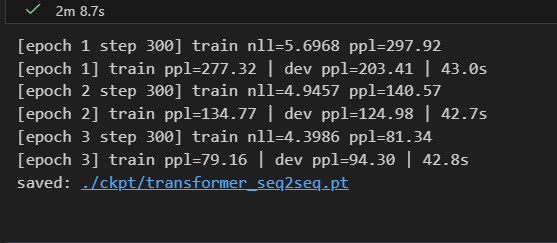